In [1]:
using PyPlot, Distributions, Statistics
using Distributions:Random
plt[:style][:use]("seaborn")

### 基本的モンテカルロ積分法

数値積分は近似しようとする関数が高次元だとうまくいかなくなることがある(**次元の呪い**.) それを解決する一つの方法として, 積分計算に**不確実性**を導入することを考える. 近似したい積分が

<br/>
$$I = \int_{E}f(x)p(x)dx$$
<br/>

と書けているとする. ただし, $P$ は確率分布, $p(x)$ は　$P$ の確率密度関数, $E$ はある状態空間(分布 $P$ が定義されている空間)である. $X_1, ..., X_M$　を分布 $P$ に従う乱数の列とすると**大数の法則**から

<br/>
$$I_M = \frac{1}{M} \sum^{M}_{m=1}f(X_m) \rightarrow_{M\rightarrow\infty}I$$
<br/>

となる. このように(擬似)乱数を用いて積分値を近似する方法を**モンテカルロ積分法**という.

#### 例1

区間 $[0, 1]$ 上に関数 $f(x)$ を

$$f(x) = (cos(50x) + sin(20x))^2$$

と定義してプロットしてみる

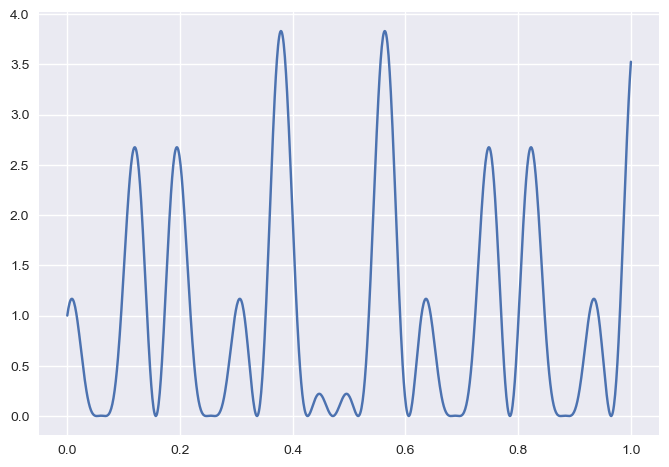

In [9]:
function f(x)
    return (cos.(50 .* x) + sin.(20 .* x)) .^ 2
end

x = collect(0.0:0.001:1.0)
plot(x, f(x), label="f(x)")
plt.show()

基本的モンテカルロ積分法で以下の積分を近似

<br/>
$$I = \int_{0}^{1}f(x)dx$$
<br/>

具体的には, 一様乱数 $u \sim U(0, 1)$ を発生させ,  $f(u)$ の平均をとる.

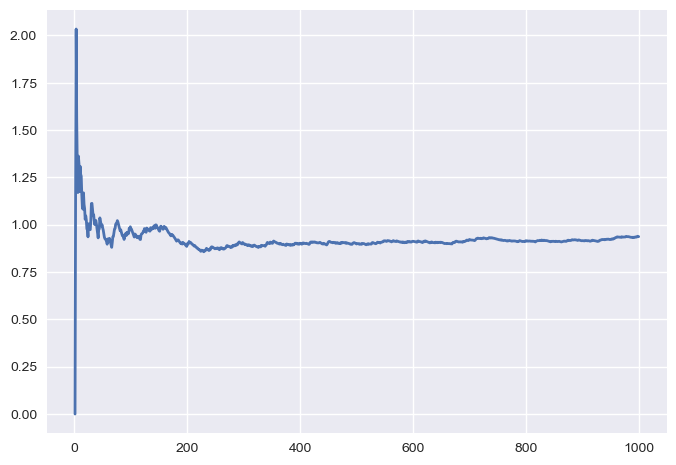

In [3]:
Random.seed!(1234)

function mc_methods(num_samples::Int)
    uni_rand = rand(num_samples)
    f_x = f(uni_rand)
    means = zeros(Float32, num_samples)
    
    for i = 2:num_samples
        means[i] = sum(f_x[1:i]) / i
    end
    
    return means
end

num_samples = 1000
x = collect(1:1:1000)
means = mc_methods(num_samples)
plot(x, means, label="mean", linewidth=2)
plt.show()

#### 例2：
$N$ 個の観測 $x_1, ..., x_N$ がコーシー分布 $C(\theta, 1)$ に従い,  パラメータ $\theta$ の事前分布が $C(0, 1)$ であると仮定する. この時の $x$ の周辺確率密度は

<br/>
$$p(x^N) = \int_{-\infty}^{\infty}p(x^N|\theta)p(\theta)d\theta$$
<br/>

この積分を基本モンテカルロ法を用いて計算するには,　$\theta$ を $C(0, 1)$ から $M$ 個生成し, 

<br/>
$$\frac{1}{M}\sum^{M}_{m=1}\prod^{N}_{n=1}\frac{1}{\pi(1 + (x_n - \theta_m)^2)}$$
<br/>

を計算すればよい.

In [4]:
N = 100
M = 1000
cauchy = Cauchy(0, 1)
x = rand(cauchy, N) .+ 1
theta = rand(cauchy, M)
means = zeros(Float64, M)

tmp = 0
for i = 1:M
    tmp += prod(1 ./ (pi .* ((x .- theta[i]).^2 .+ 1)))
    means[i] = tmp / i
end

print(tmp / M)
# iter = collect(1:1:M)
# plot(iter, means, label="mean", linewidth=2)

5.486229832248646e-94

#### 例3：
上の問題と同様にコーシー分布の裾確率を計算してみる. 積分は以下

<br/>
$$I = \int_{2}^{\infty}\frac{1}{\pi(1 + x^2)}dx$$
<br/>

今回は信頼係数95%の(近似)信頼区間もプロットしてみる.

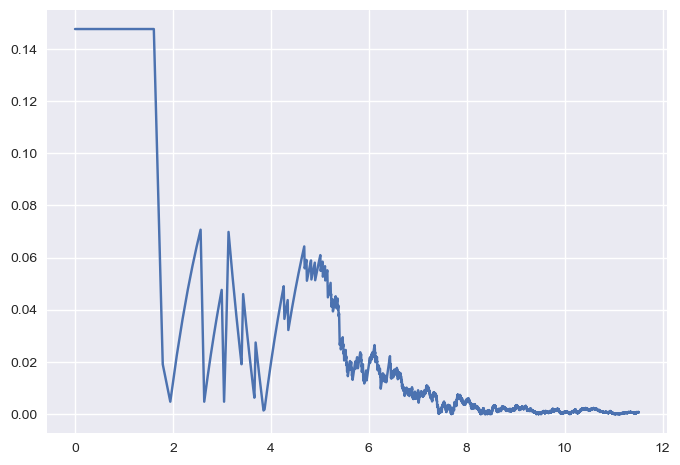

In [12]:
Random.seed!(1234)

function f(x)
    if x >= 2
        return 1
    else
        return 0
    end
end

"""
Montecarlo method
"""
function calc_I_and_CI()
    M = 100000
    cauchy_rand =rand(Cauchy(0, 1), M)
    fs = f.(cauchy_rand)
\    # MCM
    I_mean = zeros(Float32, M)
    for i = 1:M
        I_mean[i] = mean(fs[1:i])
    end
    
    # Calculate 95% CI
    sigma = zeros(Float32, M)
    for i = 2:M
        sigma[i] = (1 / (i-1)) * sum((fs[1:i] .- I_mean[i]) .^ 2) 
    end
    alpha = 0.025
    c = quantile(Normal(0, 1), 1-alpha)
    L = zeros(Float32, M) 
    U = zeros(Float32, M)
    
    for i = 1:M
        L[i] = I_mean[i] - (1 / sqrt(i)) * sqrt(sigma[i]) * c
        U[i] = I_mean[i] + (1 / sqrt(i)) * sqrt(sigma[i]) * c
    end
    
    return (I_mean, L, U)
end

M = 100000
iter = collect(1:1:M)
I_mean, L, U = calc_I_and_CI()

# True value
true_val = ones(M) ./ 2 .- atan(2) / pi

# 収束レートのプロット
diff = abs.(I_mean .- true_val)
log_iter = log.(iter)
plot(log_iter, diff)

# plot(I_mean, label="I_mean", linewidth=2)
# plot(true_val, color="red", linewidth=1, alpha=0.5)
# fill_between(iter, L, U, alpha=0.4)
plt.show()

### 自己正規化モンテカルロ積分法

#### 例：
観測が $x | \theta \sim N(\theta, 1)$ , 事前分布が $C(0, 1)$ である時の事後平均は

<br/>
$$\int^{\infty}_{-\infty}\theta p(\theta|x)d\theta = \frac{\int^{\infty}_{-\infty}\frac{\theta}{1 + \theta^2}exp(-\frac{(x-\theta)^2}{2})d\theta}{\int^{\infty}_{-\infty}\frac{1}{1 + \theta^2}exp(-\frac{(x-\theta)^2}{2})d\theta}$$
<br/>

となる. 分母と分子を基本的モンテカルロ積分で近似するには, $\theta_1, ..., \theta_M \sim N(x, 1)$ として

<br/>
$$\frac{\frac{1}{M}\sum_{m=1}^{M}\frac{\theta_m}{1 + \theta_m^2}}{\frac{1}{M}\sum_{m=1}^{M}\frac{1}{1 + \theta_m^2}}$$
<br/>

とすればよい

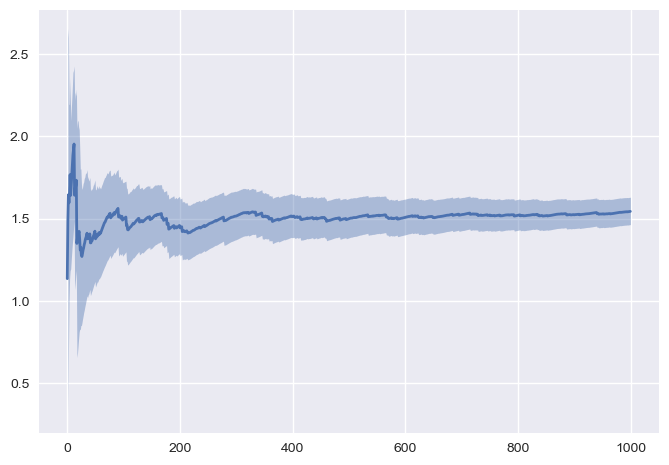

In [6]:
Random.seed!(111)

function f(theta)
    return theta / (1 + theta ^ 2)
end

function g(theta)
    return 1 / (1 + theta ^ 2)
end 

function norm_mc()
    # Define variables
    theta0 = 1.5
    x = rand(Normal(theta0, 1))
    M = 1000
    u = rand(Normal(x, 1), M)
    
    fs = f.(u)
    gs = g.(u)
    means = zeros(Float32, M)
    z = zeros(Float32, M)
     
    for i = 1:M
        f_mean = mean(fs[1:i])
        g_mean = mean(gs[1:i])
        f_var = var(fs[1:i])
        g_var = var(gs[1:i])
        fg_cov = cov(fs[1:i], gs[1:i])
        
        means[i] = f_mean / g_mean
        z[i] = means[i] ^ 2 * (f_var / f_mean ^ 2 - 2 * fg_cov / (f_mean * g_mean) + g_var / g_mean ^ 2) / i
    end
    
    # 95% CI
    alpha = 0.025
    c = quantile(Normal(0, 1), 1-alpha)
    L = means .- c .* sqrt.(z)
    U = means .+ c .* sqrt.(z)
    
    return means, L, U
end

iter = collect(1:1:1000)
means, L, U = norm_mc()
plot(means, label="mean", linewidth=2)
fill_between(iter, L, U, alpha=0.4)
plt.show()

### 重点サンプリング法

状態空間 $E$ 上に定義された分布 $P$ と, 同じ状態空間に定義された分布 $Q$ の確率密度関数を $p(x), q(x)$ とし, $q(x) = 0$ なら $p(x) = 0$ とする. また, 密度関数の割合を

<br/>
$$r(x) = \frac{p(x)}{q(x)}$$
<br/>

とおく. このとき関数 $f:E \rightarrow \mathbb{R}$ の分布 $P$ についての積分は

<br/>
$$I = \int_{E}f(x)p(x)dx = \int_{E}f(x)r(x)q(x)dx$$
<br/>

のように, $f(x)r(x)$ の分布 $Q$ に関する積分に捉え直すことができる. そのため, 基本的モンテカルロ積分法のときと同様に, $Q$ に従う確率変数列 $X_1, ..., X_M$ を用意して

<br/>
$$I_M = \frac{1}{M}\sum_{m=1}^{M}f(X_m)r(X_m)$$
<br/>

とすれば, $M \rightarrow \infty$ のとき大数の法則より $I_M \rightarrow I$ である.

<br/>

わざわざ別の分布を持ってくるという遠回りをするモチベーションは主に以下の二つである.

- うまく分布 $Q$ を選べば, Iの推定の誤差(分散)を小さくできる可能性がある(後述)
- $P$ の形が複雑で直接サンプリングが行えないときに $Q$ からのサンプリングで代用することで積分が計算できるようになる

#### 例

実数 $x$ に対し, 

<br/>
$$I = \Phi(-x) = \int_{-\infty}^{\infty}I_{\{y > x\}}\phi(y)dy$$
<br/>

とおく. ただし, $\phi(y)$ は標準正規分布の密度関数である.

<br/>

基本的モンテカルロ積分法を使ってこの積分を近似することを考える. 標準正規分布に従う確率変数列 $X_1, ..., X_M$ を用いて

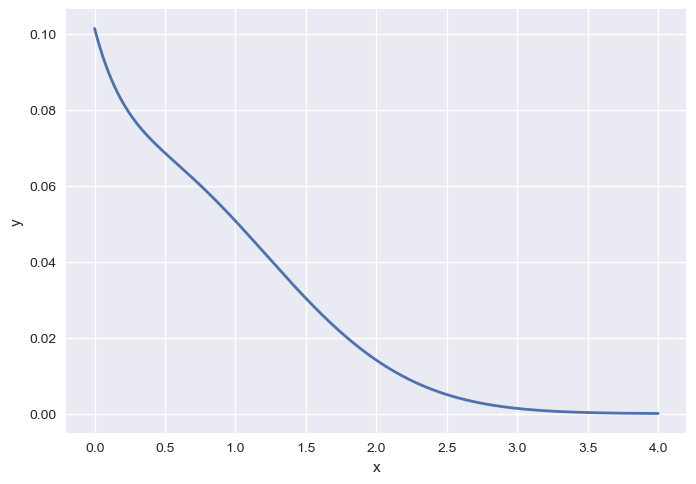

In [7]:
Random.seed!(111)


function mc_normal_var(x)
    phi_x = cdf(Normal(0, 1), -x)
    return phi_x - phi_x ^ 2
end

function mc_importance_var(x)
    return (1 / (2 * sqrt(pi))) * cdf(Normal(0, 1), -sqrt(2) * (x - 1/2)) * exp(-x + 1/4) - cdf(Normal(0, 1), -x) ^ 2
end

x = collect(0:0.01:4)
sigma_1 = mc_normal_var.(x)
sigma_2 = mc_importance_var.(x)
y = sigma_2 ./ sigma_1
xlabel("x")
ylabel("y")
plot(x, y, linewidth=2)
plt.show()

$x$ の値が大きくなるほど重点サンプリングによる分散が相対的に小さくなっていることが分かる.